# scRNA pre-processing

Import libraries and use directories

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import pycisTopic

tmp_dir = 'output'
work_dir = 'output'
os.makedirs(work_dir, exist_ok=True)

Create sparse_matrix
#### CHANGE

In [15]:
from scipy.sparse import csr_matrix
import anndata
    #from op_sc_tools.mm_utils import create_anndata
multiome_var_meta = pd.read_csv('/home/roger/Github/OpenProblems/multiome_var_meta.csv')
multiome_train = pd.read_parquet('/home/roger/Github/OpenProblems/multiome_train.parquet')
multiome_obs_meta = pd.read_csv('/home/roger/Github/OpenProblems/multiome_obs_meta.csv')
genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
    # get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [16]:
print(genes_locations)

['A1BG' 'A1BG-AS1' 'A2M' ... 'ZYG11B' 'ZYX' 'ZZEF1']


### Scanpy pipeline

         Falling back to preprocessing with `sc.pp.pca` and default params.


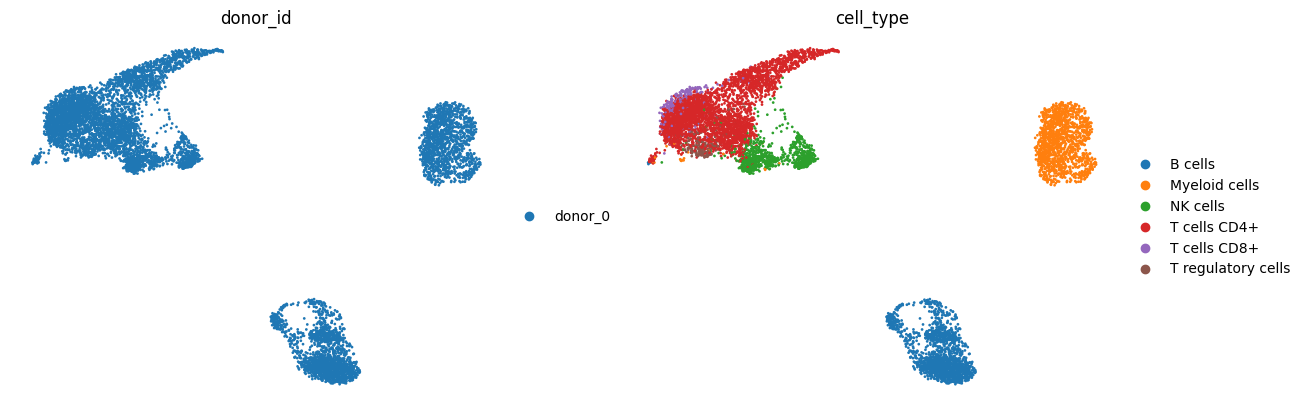

In [17]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    adata = anndata.AnnData(X=mrna_sparse_n, 
                obs=multiome_obs_meta,
                layers={'counts':mrna_sparse_raw}
                )
    adata = adata[adata.obs['donor_id']=='donor_0' ,:]
    # sc.pp.highly_variable_genes(adata, n_top_genes=2000) 
    # adata = adata[:, adata.var['highly_variable']]
    # sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=100)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['donor_id','cell_type'], frameon=False)


In [18]:
sc.tl.louvain(adata)

In [19]:
adata

AnnData object with n_obs × n_vars = 7830 × 22787
    obs: 'obs_id', 'cell_type', 'donor_id', 'louvain'
    uns: 'neighbors', 'umap', 'donor_id_colors', 'cell_type_colors', 'louvain'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Filtering

(25412, 22778)


/home/roger/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


(25412, 22778)


/home/roger/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 49.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%
(25378, 22778)


/tmp/ipykernel_16464/3537432361.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


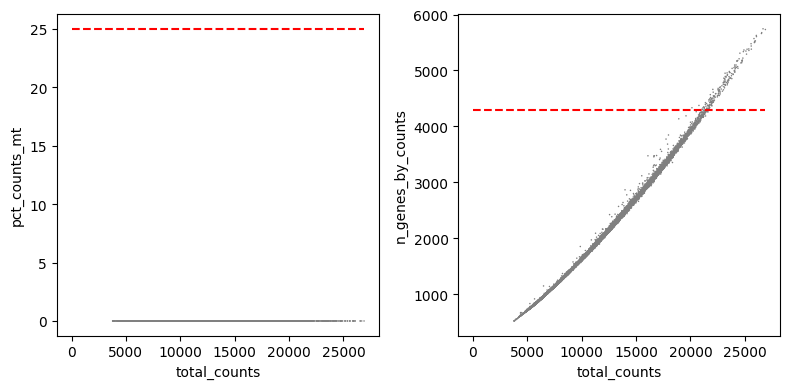

In [11]:
    #basic filtering
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)
sc.external.pp.scrublet(adata) 
adata = adata[adata.obs['predicted_doublet'] == False] 
print(adata.shape)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # adata.var = adata.var.drop(columns=['n_cells'])
import matplotlib.pyplot as plt
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
    #draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]

In [12]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=20)
sc.tl.umap(adata)

/home/roger/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


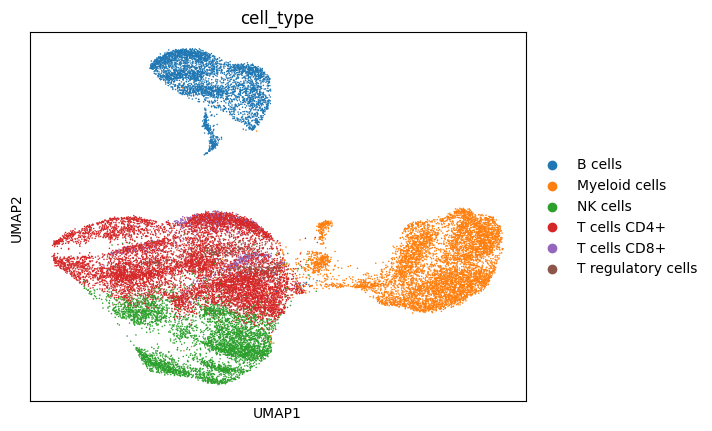

In [13]:
sc.pl.umap(adata, color="cell_type")

In [14]:
adata_donor_0 = adata[adata.obs['donor_id'] == 'donor_0']

# Imprimir el nuevo objeto AnnData
print(adata_donor_0)

View of AnnData object with n_obs × n_vars = 7728 × 22778
    obs: 'obs_id', 'cell_type', 'donor_id', 'louvain', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'umap', 'donor_id_colors', 'cell_type_colors', 'louvain', 'scrublet'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


### Save object

In [21]:
adata.write(os.path.join('/home/roger/Github/OpenProblems/Conda/pycisTopic/output/scATAC/adadata_donor_0_scenic.h5ad')) #compression='gzip')

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '22777', '22778', '22779', '22780', '22781', '22782', '22783', '22784',
       '22785', '22786'],
      dtype='object', length=22787)